In [1]:
import numpy as np
from PIL import Image
from GombNet.networks import *
from GombNet.loss_func import DiceLoss
from GombNet.utils import *
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
%matplotlib ipympl

import sys
sys.path.append('/Users/austin/Documents/GitHub/DataGenSTEM/DataGenSTEM')
import data_generator as dg

from scipy.ndimage import gaussian_filter

In [2]:
# Create dataloaders
images_dir='/Users/austin/Desktop/G_dataset_256/images'
labels_dir='/Users/austin/Desktop/G_dataset_256/labels'
train_loader, val_loader, test_loader = get_dataloaders(images_dir, labels_dir, batch_size = 1, val_split=0.2, test_split=0.1)


Train size: 700, Validation size: 200, Test size: 100


In [3]:
# Initialize model
input_channels = 1
num_classes = 2
num_filters = [32, 64, 128, 256]

model = Unet(input_channels, num_classes, num_filters, dropout = 0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = DiceLoss(alpha=2)
         

In [4]:
# Set device
if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps') # backend for Apple silicon GPUs
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
# Set the default font to Times New Roman for all text elements
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18  # Adjust the default font size if needed
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

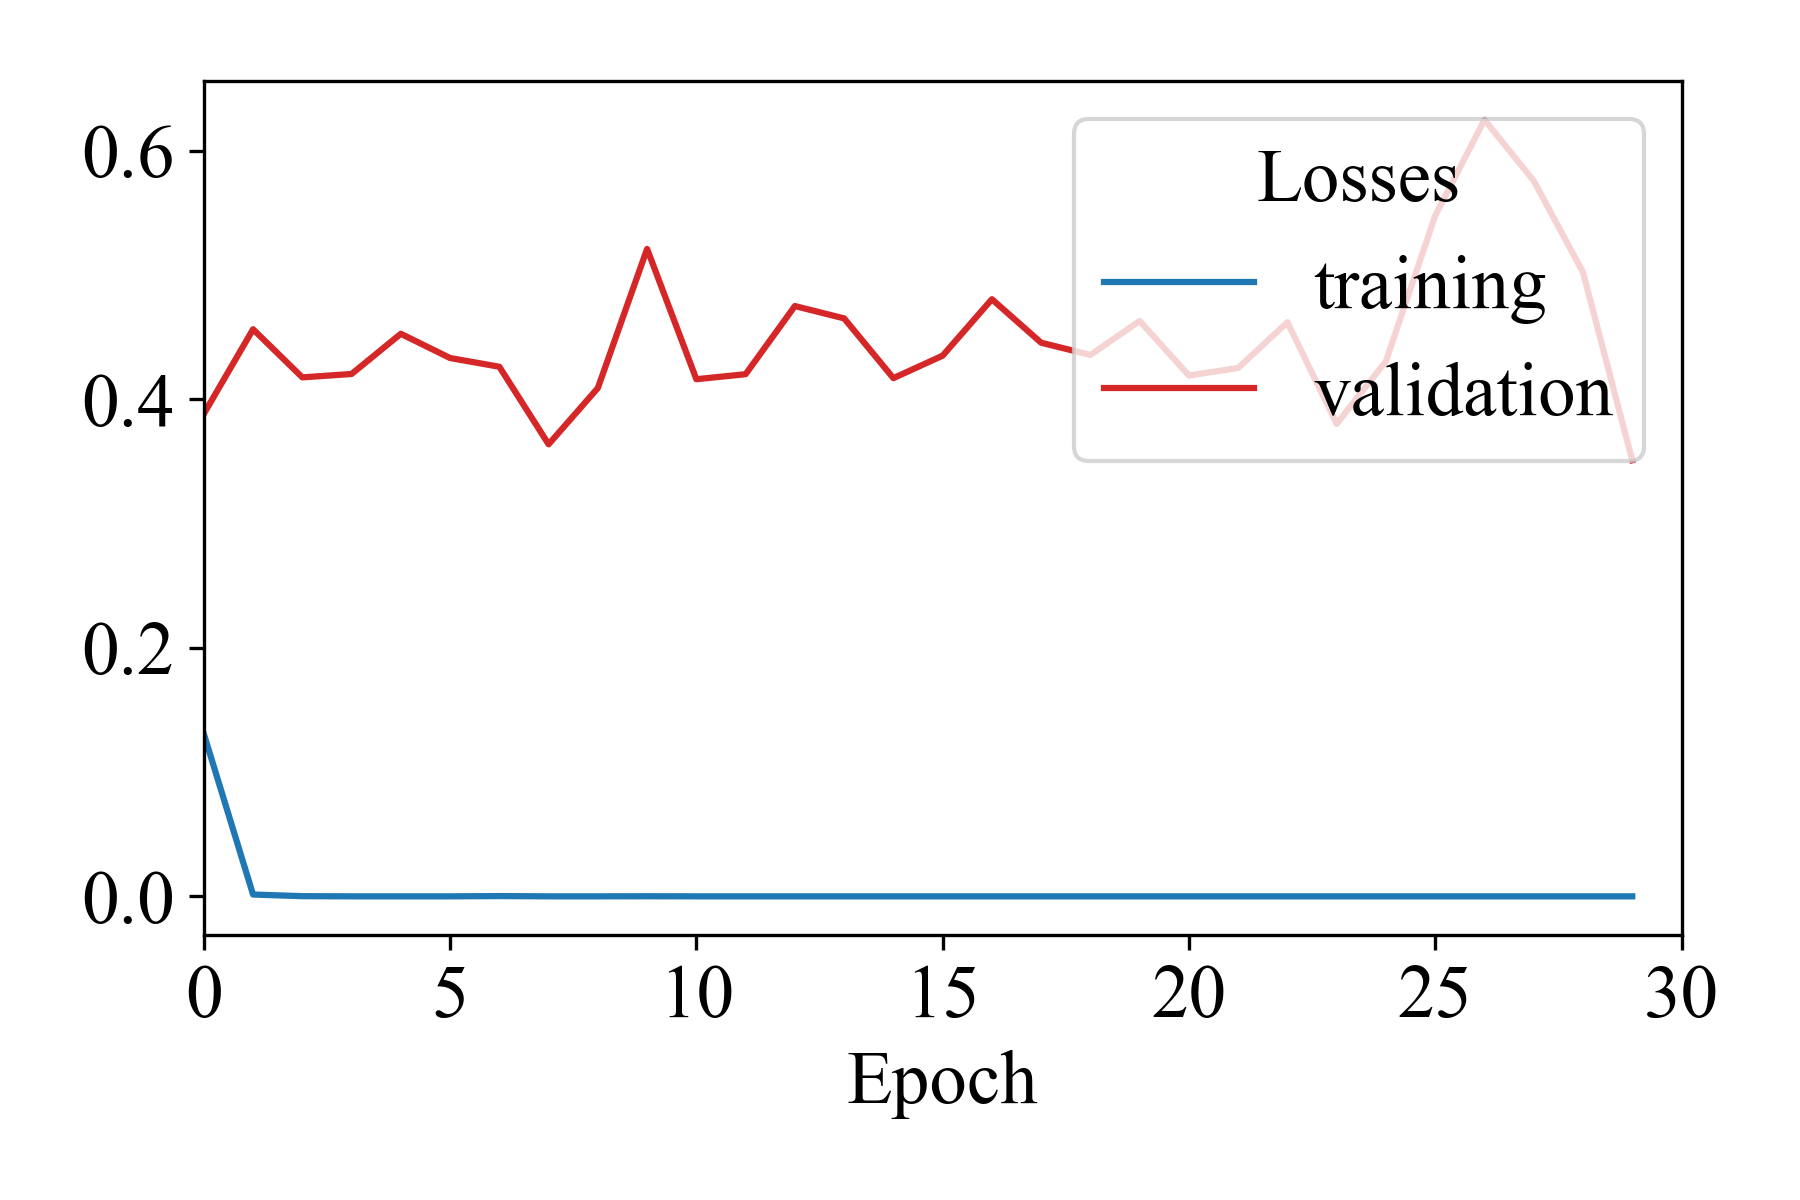

In [6]:
loss_history = np.load('/Users/austin/Documents/GitHub/GombNet/trained_models/BasicUNet256_nodrop.pthloss_history.npz')
train_loss = loss_history['train_loss_history']
val_loss = loss_history['val_loss_history']
plt.figure(dpi=300, figsize = (6,4))
plt.plot(train_loss, label='training', color = '#1f77b4')
plt.plot(val_loss, label='validation', color = '#d62728')
plt.xlabel('Epoch')
plt.xlim(0,30)
plt.legend(title='Losses', loc='upper right')
plt.tight_layout()  



In [7]:
test_iter = 1

train = train_loader.dataset[test_iter][0].unsqueeze(0)
test = test_loader.dataset[test_iter][0].unsqueeze(0)
gt = test_loader.dataset[test_iter][1]

In [8]:
model_path = '/Users/austin/Documents/GitHub/GombNet/trained_models/BasicUNet256_nodrop.pth'
# model.to(device)
checkpoint = torch.load(model_path, map_location=torch.device('mps'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

Unet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv_block): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [9]:
# Generate prediction
with torch.no_grad():
    #test.to(device)
    probability = model(test)
    prediction = F.sigmoid(probability)#>0.50
probability = probability.squeeze().cpu().numpy() 
prediction = prediction.squeeze().cpu().numpy()

threshold = threshold_otsu(prediction)
prediction = (prediction > threshold).astype(float)


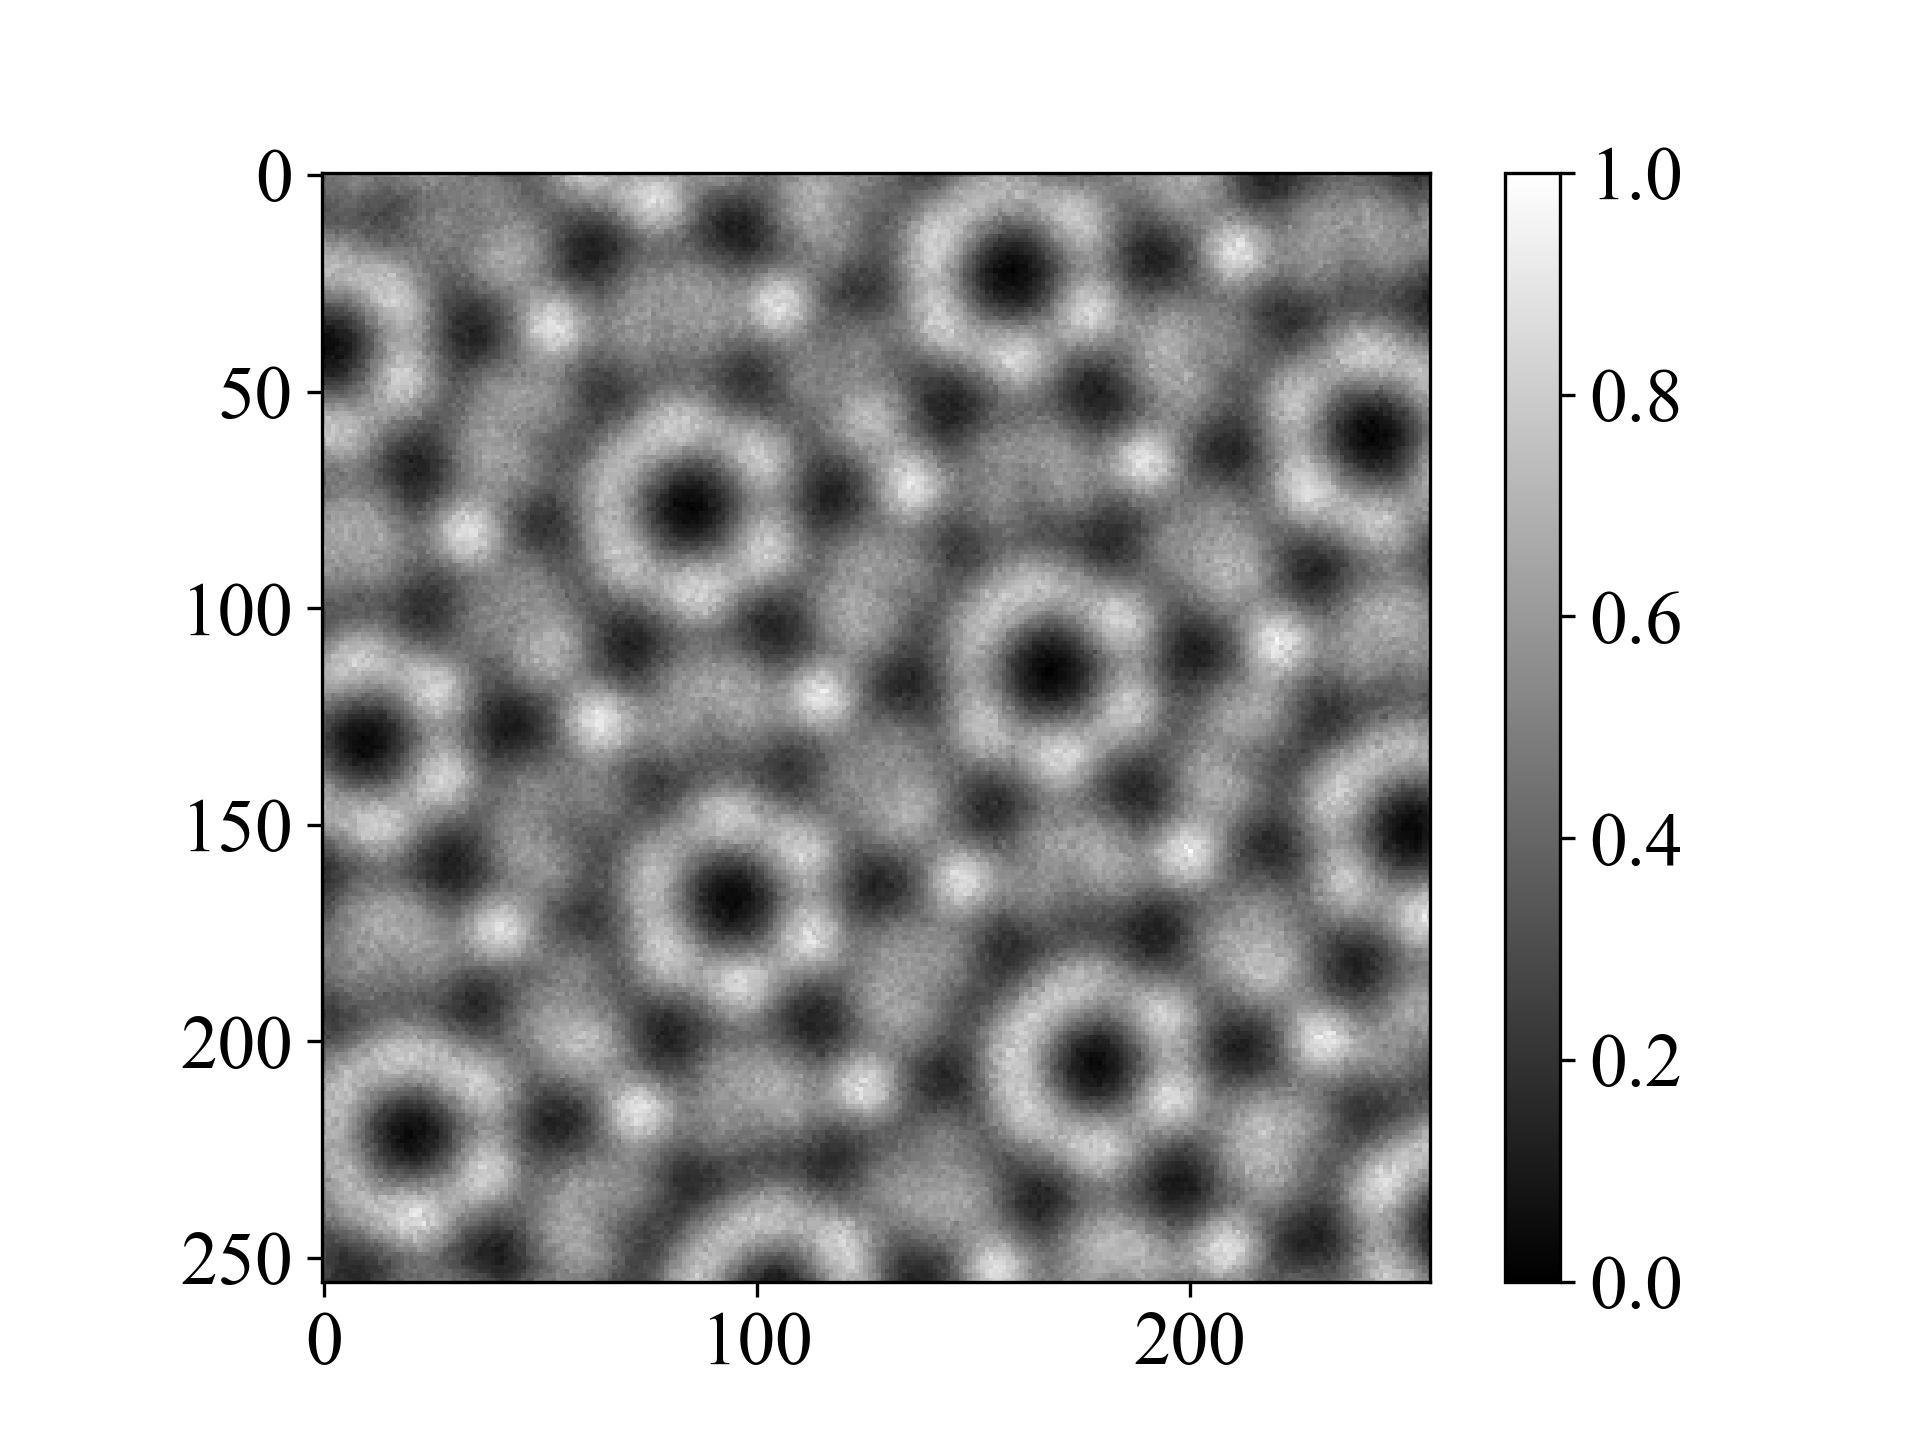

In [17]:
plt.figure(dpi=300)
plt.imshow(test.squeeze().cpu().numpy(), cmap='gray')
plt.colorbar()

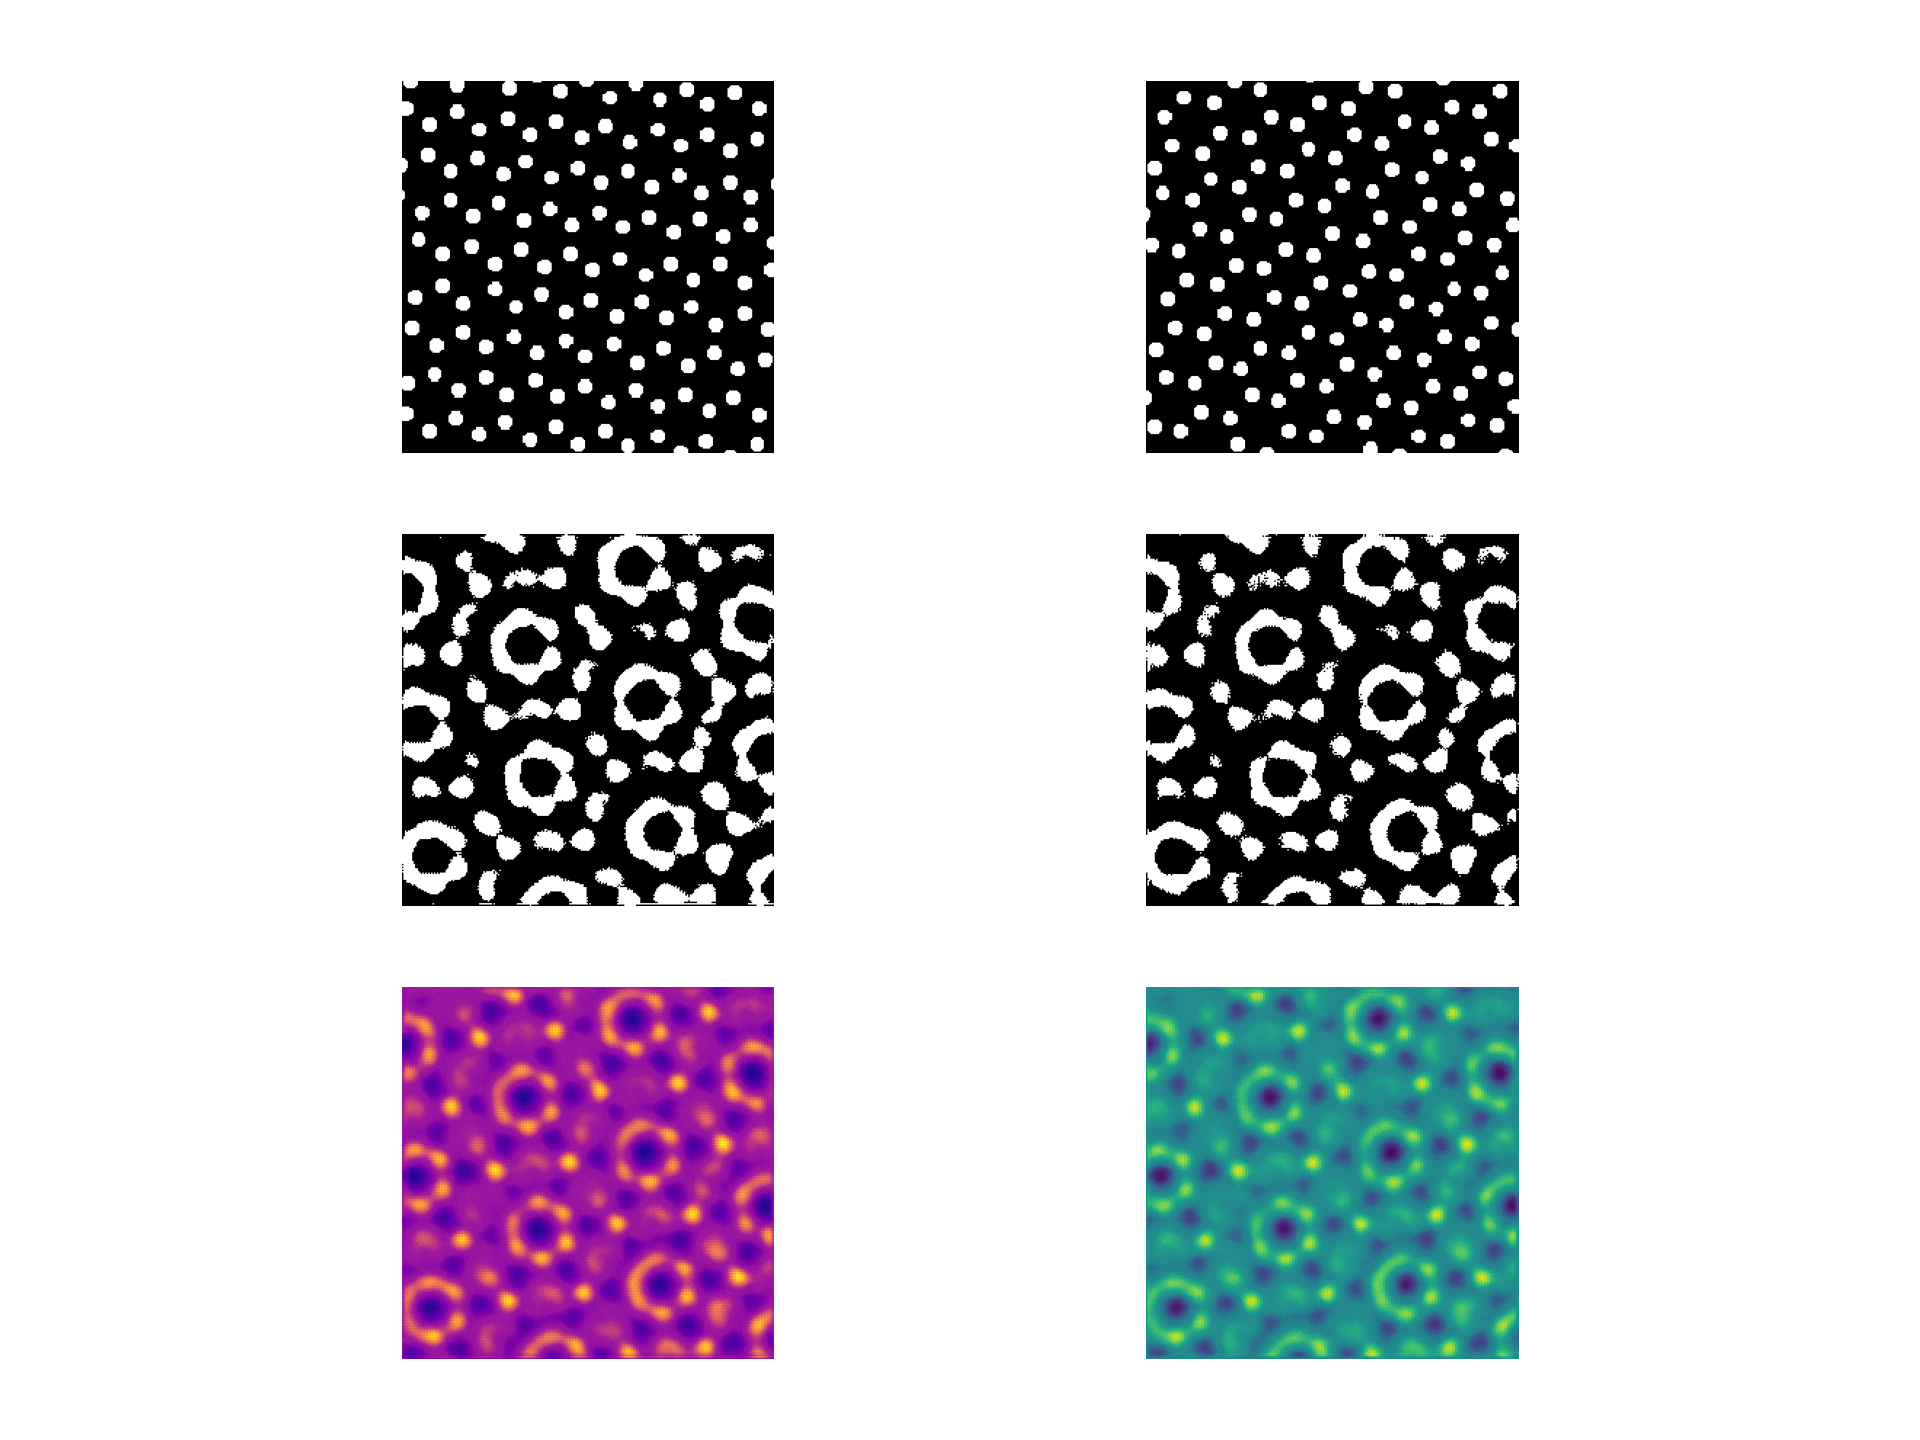

In [18]:
# Plotting
num_classes
fig, axs = plt.subplots(3,num_classes, sharex=True, sharey=True, dpi=300)

for i in range(num_classes):
    axs[0,i].imshow(gt[i], cmap='gray')

for i in range(num_classes):
    axs[1,i].imshow(prediction[i], cmap='gray')

for i in range(num_classes)[:1]:
    axs[2,i].imshow(probability[i], cmap='plasma')
for i in range(num_classes)[1:]:
    axs[2,i].imshow(probability[i], cmap='viridis')


for ax in axs.ravel():
    ax.axis('off')

axs[0,0].set_ylabel('GrounTruth')
axs[1,0].set_ylabel('Prediction')
axs[2,0].set_ylabel('Probability')


fig.tight_layout()

In [12]:
pwa_total = 0
dice_total = 0
IoU_total = 0

def iou(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union

def dice_coefficient(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return 2 * intersection / (pred.sum() + gt.sum())

# Calculate the accuracy
for i in range(len(test_loader)):
    test = test_loader.dataset[i][0].unsqueeze(0)
    gt = test_loader.dataset[i][1].numpy()  # Convert to numpy array
    
    # Switch ground truth layers
    gt_switched = np.flip(gt, axis=0)
    
    with torch.no_grad():
        probability = model(test)
        prediction = torch.sigmoid(probability)  # Use torch.sigmoid instead of F.sigmoid (deprecated)
    
    probability = probability.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    threshold = threshold_otsu(prediction)
    prediction = (prediction > threshold).astype(float)
    
    # Calculate metrics for original and switched ground truths
    pwa_original = np.sum(prediction == gt) / np.prod(gt.shape)
    pwa_switched = np.sum(prediction == gt_switched) / np.prod(gt_switched.shape)
    
    dice_original = dice_coefficient(prediction, gt)
    dice_switched = dice_coefficient(prediction, gt_switched)
    
    iou_original = iou(prediction, gt)
    iou_switched = iou(prediction, gt_switched)
    
    # Take the highest value for each metric
    pwa_total += max(pwa_original, pwa_switched)
    dice_total += max(dice_original, dice_switched)
    IoU_total += max(iou_original, iou_switched)

# Calculate the average for each metric
pwa_total /= len(test_loader)
dice_total /= len(test_loader)
IoU_total /= len(test_loader)

print(f"Pixel-wise Accuracy: {pwa_total}")
print(f"Mean Dice Coefficient: {dice_total}")
print(f"Mean IoU: {IoU_total}")

Pixel-wise Accuracy: 0.6202590179443359
Mean Dice Coefficient: 0.4240558494984492
Mean IoU: 0.27027351001471744


In [13]:
def get_activations_by_layer(model, x):
    activations = []
    hooks = []
    layer_names = []

    def hook_fn(module, input, output):
        # If the output is a tuple, extract the first element
        if isinstance(output, tuple):
            output = output[0]
        activations.append(output)

    def register_hooks(module, name_prefix=''):
        if isinstance(module, nn.Module):
            hooks.append(module.register_forward_hook(hook_fn))
        for name, child in module.named_children():
            full_name = f"{name_prefix}{name}"
            register_hooks(child, full_name + '.')
            layer_names.append(full_name)

    # Register hooks recursively
    register_hooks(model, '')

    # Forward pass
    with torch.no_grad():
        model(x)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return activations, layer_names



def plot_activations(activations, layer_names):
    num_layers = len(activations)
    fig, axs = plt.subplots(num_layers, min(8, max(activation.shape[1] for activation in activations if isinstance(activation, torch.Tensor))), figsize=(20, 2 * num_layers))

    for i, activation in enumerate(activations):
        num_channels = activation.shape[1] if isinstance(activation, torch.Tensor) else 1
        
        for j in range(min(num_channels, 8)):
            ax = axs[i, j] if num_layers > 1 else axs[j]
            if isinstance(activation, torch.Tensor):
                ax.imshow(activation[0, j].cpu().numpy(), cmap='viridis')
            else:
                ax.text(0.5, 0.5, str(activation), fontsize=12, ha='center')
            ax.axis('off')
        
        # Set the title for the row
        layer_name = layer_names[i] if layer_names is not None else f'Layer {i}'
        axs[i, 0].set_title(layer_name, fontsize=16, loc='left')

    plt.tight_layout()
    plt.show()

In [14]:
activations, layer_names = get_activations_by_layer(model, test)



In [15]:
# plot_activations(activations, layer_names)

In [16]:
import matplotlib.pyplot as plt

def plot_activations(activations, categories, layer_names):
    num_layers = len(activations)
    fig, axs = plt.subplots(num_layers, min(8, max(activation.shape[1] for activation in activations)), figsize=(20, 2 * num_layers))

    for i, (activation, category) in enumerate(zip(activations, categories)):
        num_channels = activation.shape[1]
        
        for j in range(min(num_channels, 8)):
            ax = axs[i, j] if num_layers > 1 else axs[j]
            ax.imshow(activation[0, j].cpu().numpy(), cmap='viridis')
            ax.axis('off')
        
        # Set the title for the row
        layer_name = layer_names[i] if layer_names is not None else f'Layer {i}'
        axs[i, 0].set_title(f'{category.capitalize()} - {layer_name}', fontsize=16, loc='left')

    plt.tight_layout()
    plt.show()

# Example usage of plotting function
plot_activations(activations, categories, layer_names)

NameError: name 'categories' is not defined

In [ ]:
# Read in the image
#img = Image.open('./expdata/MAADF108.tiff')
img = Image.open('/Users/austin/Desktop/Projects/MoS2_isotope_growth/code/expdata/HAADF115.tiff')
img = np.array(img).astype('float32')
img = img - img.min()
img = img / img.max()
img = gaussian_filter(img, 1)


ims = dg.shotgun_crop(img, crop_size=470, magnification_var = None, n_crops=10, seed=42, return_binary = False, roi = 'middle')
ims = [dg.resize_image(im, 512) for im in ims]
ims = [gaussian_filter(im, 1) for im in ims]
ims = np.array(ims)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')

ax2.imshow(ims[2], cmap='gray')
ax2.set_title('Resized Image')

ax1.axis('off')
ax2.axis('off')


# make test type torch.FloatTensor
test = torch.from_numpy(ims).unsqueeze(1).float()

NameError: name 'activationsplt' is not defined

In [ ]:
# Generate prediction
with torch.no_grad():
    probability = model(test)
    prediction = F.sigmoid(probability)>0.50
probability = probability.squeeze().cpu().numpy() 
prediction = prediction.squeeze().cpu().numpy()

In [ ]:
batch = 2
fig, axs = plt.subplots(2,5,figsize=(18, 10), sharex=True, sharey=True)

axs[0,0].imshow(ims[batch], cmap='gray')

for i in range(num_classes):
    axs[0,i+1].imshow(prediction[batch,i], cmap='viridis')
    axs[1,i+1].imshow(probability[batch,i], cmap='plasma')


fig.tight_layout()

In [ ]:
prediction = prediction.astype(int)
test_image = test.cpu().squeeze().numpy()



In [ ]:
from scipy.ndimage import label, center_of_mass

batch = 2
# make the plots the same size
fig, ax = plt.subplots(1,3,figsize=(15, 10), sharex=True, sharey=True)

threshold_area = 10

atoms = []
layer_indexes = [1,4]
layer_names = ['Mo_A', 'Mo_B']
colors = ['hotpink', 'darkviolet']
for i, n in enumerate(layer_indexes):
    layer = prediction[batch,n]
    labels, num_features = label(layer)

    # filter out small blobs
    for feature_id in range(1, num_features + 1):
        blob_area = (labels == feature_id).sum()
        if blob_area < threshold_area:
            labels[labels == feature_id] = 0

    com = center_of_mass(layer, labels, range(1, num_features+1))
    atoms.append(np.array(com))

    ax[i].imshow(test_image[batch], cmap='gray')
    ax[i].scatter([c[1] for c in com], [c[0] for c in com], color = colors[i], s=50, label = layer_names[i])
    ax[i].axis('off')

ax[2].imshow(test_image[batch], cmap='gray')
ax[2].axis('off')

fig.tight_layout()